In [8]:
import duckdb
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config

In [9]:
def fetch_rushes():
	pass

In [10]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"down",
	"goal_to_go",
	"ydstogo",
	"posteam_score",
	"defteam_score",
	"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	'game_seconds_remaining',
	#"wind",
	#"temp",
	'spread_line',
	'total_line'
]

x_cols = game_context_cols + rusher_stat_cols + team_stat_cols + opp_stat_cols

In [11]:
rushes = Quack.query(f"""
select pbp.game_id, pbp.yards_gained,
	{', '.join(('pbp.' + x for x in game_context_cols))},
	{', '.join(('t.' + x for x in team_stat_cols))},
	{', '.join(('o.' + x for x in opp_stat_cols))},
	{', '.join(('r.' + x for x in rusher_stat_cols))},
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.rusher_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
""")

In [12]:
rushes[rusher_stat_cols] = rushes[rusher_stat_cols].fillna(0)
rushes['yards_shifted'] = rushes['yards_gained'] + 30

In [13]:
import torch
import torch.nn as nn

class masked_model(nn.Module):
	def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.):
		super(masked_model, self).__init__()
		self.n_out=n_out
		self.main_layers = nn.Sequential(
		nn.Linear(n_in, n_hidden),nn.ReLU(),
		nn.Linear(n_hidden, n_hidden),nn.ReLU(),
		nn.Dropout(p=dropout_prob),
		nn.Linear(n_hidden, n_hidden),nn.ReLU(),
		)
		self.add_yardline = nn.Linear(n_hidden + 1, n_out)
	def forward(self, x):
		# Extract the feature to pass to the final layer (e.g., the first feature)
		feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]

		x = self.main_layers(x)
		x = torch.cat((x, feature_to_pass), dim=1) 
		x = self.add_yardline(x)



		#end_zone = feature_to_pass[:,0].clone().detach().view(-1)
		#accum_mask = torch.nn.functional.one_hot(end_zone.type(torch.LongTensor)+30, self.n_out)
		#accum_mask =  accum_mask +  torch.sum(accum_mask, dim=1, keepdims=True) - torch.cumsum(accum_mask, dim=1)
		#accum_mask = accum_mask.type(torch.bool)
		#x = x.masked_fill(~accum_mask, float('-1000'))

		return x

In [30]:
class OrdinalNet(nn.Module):
	def __init__(self, in_dim, n_hidden, num_classes):
		super().__init__()
		self.feature_extractor = nn.Sequential(
			nn.Linear(in_dim, n_hidden),
			nn.ReLU(),
			nn.Linear(n_hidden, n_hidden),
			nn.ReLU()
		)
		# shared projection to 1 logit
		self.fc = nn.Linear(n_hidden, 1)
		# K-1 thresholds (biases)
		self.biases = nn.Parameter(torch.zeros(num_classes-1))

	def forward(self, x):
		h = self.feature_extractor(x)              # (batch, n_hidden)
		logit = self.fc(h)                         # (batch, 1)
		logit = logit.expand(-1, 131-1)    # (batch, K-1)
		logits = logit - self.biases               # apply thresholds
		return logits

In [31]:
min_y, max_y = -30, 100
num_classes = max_y - min_y + 1

def coral_loss(logits, y):
    """
    logits: (batch, K-1)
    y: true labels in [-30,100]
    """
    y_shifted = y - min_y
    # create mask: for class c, positive for thresholds < c
    # e.g. y=3 → [1,1,1,0,0,...]
    y_expand = torch.arange(logits.size(1), device=y.device).unsqueeze(0)
    target = (y_expand < y_shifted.unsqueeze(1)).float()
    return F.binary_cross_entropy_with_logits(logits, target)

In [32]:
X = rushes[x_cols]
y = rushes['yards_shifted']
obs = len(X)
num_feats = len(X)

In [50]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)

def get_sample(num_samples):
	idx = np.random.randint(0,len(X_tensor), num_samples)
	return X_tensor[idx]

get_sample(2)

model = OrdinalNet(len(x_cols), n_hidden=32, num_classes=num_classes)
			# numerical value
c = get_sample(3)
print(c.shape)
pred = model(c)
pred

torch.Size([3, 21])


tensor([[-110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.9490, -110.9490, -110.9490, -110.9490, -110.9490,
         -110.9490, -110.

In [34]:
def predict(model, X):
    with torch.no_grad():
        logits = model(X)                 # (batch, K-1)
        probs = torch.sigmoid(logits)     # P(y > threshold)
        # Count how many thresholds are passed
        preds = probs.sum(dim=1).long() + min_y
    return preds

In [47]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=512):

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	y = torch.tensor(y,dtype=torch.long).to(device)
	# Define the model, loss function, and optimizer

	X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
	model = OrdinalNet(n_in, n_hidden=32, num_classes=num_classes).to(device)
	#criterion = nn.CrossEntropyLoss()  # Suitable for classification
	optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.1)

	num_samples = X_tensor.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices

	Xtr = X_tensor[train_indices].to(device)
	Xtst = X_tensor[test_indices].to(device)
	train_y = y[train_indices].to(device)
	test_y =  y[test_indices].to(device)

	# Training loop
	epochs = epochs
	batch_size = 64

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			indices = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[indices], train_y[indices]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]


			loss = coral_loss(outputs, batch_y)  # batch_y must be [batch_size] with class indices
			loss.backward()
			optimizer.step()

			epoch_loss += loss.item()

		print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(Xtr):.4f}")

		# Evaluation on the test set
	model.eval()
	with torch.no_grad():
		test_logits = model(Xtst)  # shape: [N, K-1]
		test_loss = coral_loss(test_logits, test_y).item()
		
		# Convert thresholds → class probabilities
		sigm = torch.sigmoid(test_logits)           # P(y > threshold)
		p_ge = torch.cat([torch.ones_like(sigm[:, :1]), sigm], dim=1)    # prepend 1
		p_le = torch.cat([1 - sigm, torch.zeros_like(sigm[:, :1])], dim=1)  # append 0
		class_probs = p_ge * p_le    # shape [N, K], proper distribution
		
		# Accuracy by argmax
		preds = class_probs.argmax(dim=1) + min_y
		accuracy = (preds == test_y).float().mean().item()
	print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

	probs = class_probs[0].cpu()
	samples = torch.multinomial(probs, 100, replacement=True) + min_y
	avg = round(samples.double().mean().item(), 3)

	import matplotlib.pyplot as plt
	plt.hist(samples.numpy(), alpha=0.5, color='r')
	plt.hist(test_y.cpu().numpy(), alpha=0.5, color='b')
	plt.show()
	return model

Epoch 1/5, Loss: 0.0117
Epoch 2/5, Loss: 0.0106
Epoch 3/5, Loss: 0.0106
Epoch 4/5, Loss: 0.0106
Epoch 5/5, Loss: 0.0106
Test Loss: 0.6762, Test Accuracy: 0.0000


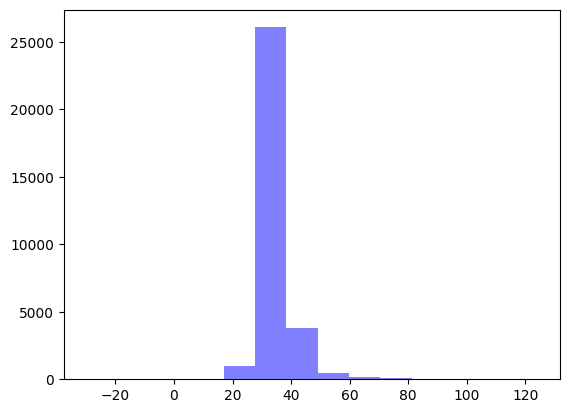

In [48]:
rush_yards_model = train_model(X,y, len(x_cols), 130, n_hidden = 512, epochs=5) # 2.937 loss, 0.1279 acc


In [40]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

Actual mean: 4.08, Model mean: 1113.63


array([0.49354705, 0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 ,
       0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 ,
       0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 ,
       0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 ,
       0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 ,
       0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 ,
       0.2499581 , 0.2499581 , 0.2499581 , 0.2499581 , 0.24996306,
       0.24995823, 0.24995823, 0.24995823, 0.24995823, 0.24995823,
       0.24995825, 0.24995823, 0.24995823, 0.2499582 , 0.24995823,
       0.24995843, 0.24995816, 0.24994841, 0.24995811, 0.24995868,
       0.2499725 , 0.24996279, 0.24994181, 0.24999416, 0.25000817,
       0.24990056, 0.24998315, 0.2500122 , 0.25024536, 0.2502683 ,
       0.2507297 , 0.25125906, 0.2511289 , 0.25116044, 0.25094095,
       0.25068057, 0.25051466, 0.25032166, 0.25011975, 0.25017443,
       0.2499686 , 0.25021514, 0.24997649, 0.25005534, 0.25006

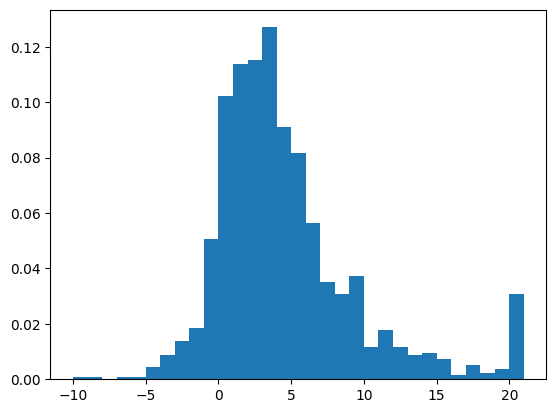

In [45]:
def sample_model_yardline(yard):
    inp = rushes.loc[rushes.yardline_100 == yard, x_cols]
    inp = torch.tensor(inp.values, dtype=torch.float32)

    with torch.no_grad():
        logits = rush_yards_model(inp)  # [N, K-1]
        sigm = torch.sigmoid(logits)    # [N, K-1]

        # reconstruct probabilities per sample
        p_ge = torch.cat([torch.ones_like(sigm[:, :1]), sigm], dim=1)
        p_le = torch.cat([1 - sigm, torch.zeros_like(sigm[:, :1])], dim=1)
        probs_per_sample = p_ge * p_le  # [N, K]

        # then average across batch
        class_probs = probs_per_sample.mean(0).cpu().numpy()

    # ground truth
    y = rushes.loc[rushes.yardline_100 == yard, ['yards_gained']]
    plt.hist(y, range(-10, yard+2), density=True)

    actual_mean = y['yards_gained'].mean()
    model_mean = (np.arange(len(class_probs)) + min_y) @ class_probs
    print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")

    return class_probs

yard = 20
sample_model_yardline(yard)


Actual mean: 4.08, Model mean: 5.92


(-10.0, 30.0)

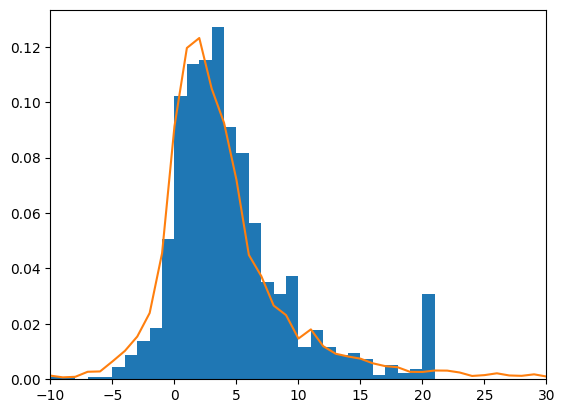

In [ ]:
def sample_model_yardline(yard):
	inp = rushes.loc[rushes.yardline_100 == yard, x_cols]
	inp =  torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).mean(0).detach().numpy()
	exp_logits = np.exp(out - np.max(out))
	probs = exp_logits / exp_logits.sum()
	y = rushes.loc[rushes.yardline_100 == yard, ['yards_gained']]
	plt.hist(y, range(-10,yard+2), density=True)

	actual_mean = y['yards_gained'].mean()
	model_mean = (np.arange(len(probs)) - 30) @ probs  # adjust if 0th class = -30
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	
	return probs

yard = 20
plt.plot(range(-30 ,100 ),sample_model_yardline(yard))
plt.xlim(-10,30)

Actual mean: 4.08, Model mean: 5.92


np.float32(1.0000001)

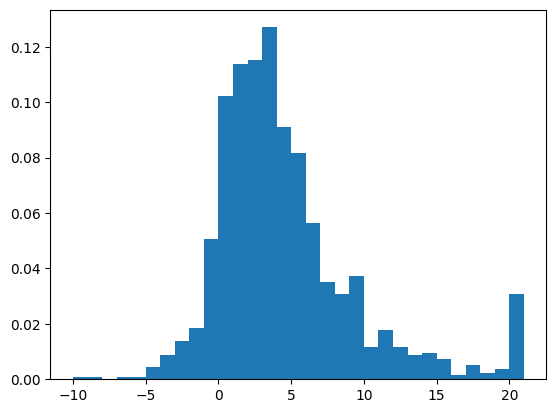

In [14]:
sample_model_yardline(yard).sum()

In [15]:
inp = rushes.loc[rushes.yardline_100 == 12, x_cols]
inp =  torch.tensor(inp.values, dtype=torch.float32).to('cuda')
out = rush_yards_model(inp).detach().to('cpu').numpy()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
out[1]

array([ 3.0577316e+01,  8.3648567e+00,  3.0976414e+01, -1.1682503e+01,
       -2.5396679e+01,  1.4427182e+01, -5.1124196e+00, -6.5609226e+00,
       -1.2155319e+01,  5.5415535e-01,  2.2516848e+01,  9.2488918e+00,
        1.0456581e+01, -8.4359074e+00, -3.1588428e+01,  1.1285777e+00,
        1.9616150e+01,  4.3648090e+01,  9.6136084e+00,  2.0499018e+01,
       -8.5107441e+00, -2.6684216e+01, -5.4211952e+01,  2.1535923e+01,
        4.1447224e+01,  3.3208084e+01,  2.8367538e+01, -6.7429657e+00,
        2.8574100e+01, -2.0131948e+01, -1.9171776e+01,  7.3409149e+01,
       -7.9693413e-01,  1.3057470e+00,  1.1936997e+01, -2.7403105e+01,
        1.0026169e+00,  3.9317532e+00, -8.3897676e+00, -5.6361544e-01,
       -1.7061863e+00,  2.0738796e+01,  1.4764082e+01,  4.2341623e+00,
        3.7908234e+01, -2.8203468e+00,  1.7409246e+01,  6.8200216e+00,
       -1.5049698e+01, -1.3360697e+01, -3.1074715e+00, -1.1046360e+01,
        3.3717896e+01, -8.5440722e+00,  1.3663624e+01, -1.9123282e+00,
      

In [ ]:
test_inp = torch.tensor(inp.values, dtype=torch.float32)

torch.Size([1, 21])
torch.Size([1, 21])
torch.Size([1, 21])
torch.Size([1, 21])


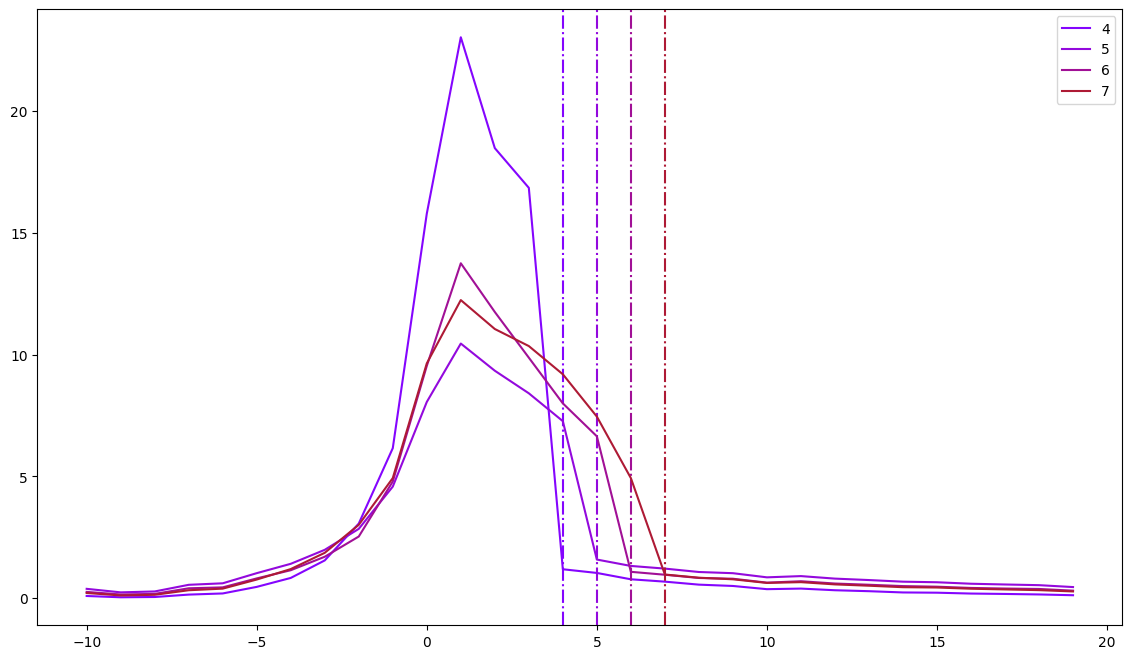

In [17]:
import matplotlib.cm as cm
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 15
for yardline in range(4,8):

    color = colormap(yardline / num_yardlines) 
    down=1
    test = rushes.loc[rushes.yardline_100==yardline]
    xx = torch.Tensor(test[x_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = rush_yards_model(xx)
        xy[:,30+yardline:] /= 2
        xy = (100 * F.softmax(xy,dim=1))[0]
        x_range = range(-10,20)
    plt.axvline(yardline, color=color, linestyle='-.')
    plt.plot(x_range, xy[20:50], label=yardline, color=color)
    plt.legend()